# Misinformation Detection
### Model Training Notebook

*Session 20 Group 4*
*Erica, Sahan, Dinuka*

### Setup (always run these):

Imports:

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltkstopwords
from gensim.models import Word2Vec
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from dbcv import dbcv
import copy
import umap

Setup:

In [5]:
# Read in dataset
dataset = pd.read_csv("data/processed_dataset.csv", index_col=0)

display(dataset.head())

# Define universal stopwords
stopwords = set(nltkstopwords.words('english'))
stopwords.update(['said', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'wouldn'])
STOPWORDS = list(stopwords)

RANDOM_STATE = 17

# Initialise classifier models to be tested with their hyperparameters
CLASSIFIER_MODELS = {
    "Logistic Regression": LogisticRegression(max_iter=2000, n_jobs=-1),
    "Naive Bayes": MultinomialNB(alpha=1e-8),
    "Linear SVM": LinearSVC(penalty='l2', max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=20, n_jobs=-1)
}

CLASSIFIER_MODELS_SEMANTIC = {
    "Logistic Regression": LogisticRegression(max_iter=2000, n_jobs=-1),
    "Naive Bayes": GaussianNB(var_smoothing=1e-8),
    "Linear SVM": LinearSVC(penalty='l2', max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=20, n_jobs=-1)
}

# Training and evaluator function for classifiers
def train_and_eval_classifier(model, X_train, X_test, y_train, y_test):
    training_model = copy.deepcopy(model)
    training_model.fit(X_train, y_train)
    
    y_pred = training_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='real')
    recall = recall_score(y_test, y_pred, pos_label='real')
    f1 = f1_score(y_test, y_pred, pos_label='real')
    return accuracy, precision, recall, f1

,text,label
0,the reason why jade helm is obama favorite con...,fake
1,us president donald trump revised hardline pol...,real
2,brazilian congressional report recommended on ...,real
3,ah the simpsons the hilarious animated show th...,fake
4,says former fbi director james comey admitted ...,fake


### Manually Extracting Features

Using specific highly label-correlated bigrams. These are sourced from the data visualisation notebook.

"president donald", "washington reuters", "told reporters", "told reuters", "house representatives", "us president", "getty images", "image via", "featured image" are all probably significantly correlated with labels enough to consider using them for features.

In [23]:
TARGET_BIGRAMS = [
    ("president", "donald"),
    ("washington", "reuters"),
    ("told", "reporters"),
    ("told", "reuters"),
    ("house", "representatives"),
    ("us", "president"),
    ("getty", "images"),
    ("image", "via"),
    ("featured", "image")
]

We now count the instances of each of these bigrams in each document, and save these as new feature columns.

In [24]:
nltk.download('punkt')
nltk.download('punkt_tab')

def count_target_bigrams(text, target_bigrams):
    tokens = nltk.word_tokenize(text.lower())
    bigrams_in_text = list(ngrams(tokens, 2))
    bigram_counts = Counter(bigrams_in_text)
    
    return {f"{w1}_{w2}": bigram_counts.get((w1, w2), 0) for (w1, w2) in target_bigrams}

bigram_features_df = dataset['text'].apply(lambda x: count_target_bigrams(x, TARGET_BIGRAMS)).apply(pd.Series)

expanded_dataset = pd.concat([dataset, bigram_features_df], axis=1)
expanded_dataset.head(5)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,text,label,president_donald,washington_reuters,told_reporters,told_reuters,house_representatives,us_president,getty_images,image_via,featured_image
0,the reason why jade helm is obama favorite con...,fake,0,0,0,0,0,0,0,0,1
1,us president donald trump revised hardline pol...,real,1,0,0,0,0,1,0,0,0
2,brazilian congressional report recommended on ...,real,0,0,0,0,0,0,0,0,0
3,ah the simpsons the hilarious animated show th...,fake,0,0,0,0,0,0,0,1,1
4,says former fbi director james comey admitted ...,fake,0,0,0,0,0,0,0,0,0


### Training Classifier Models on Manually Extracted Features

In [ ]:
bigram_feature_cols = [f"{w1}_{w2}" for w1, w2 in TARGET_BIGRAMS]

X = expanded_dataset[bigram_feature_cols].fillna(0).values
y = expanded_dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

scaler = MinMaxScaler(feature_range=(0,1)) # Scaler is used to normalise the data. Range of 0, 1 is used since Naive Bayes requires positive values.
X_train = scaler.fit_transform(X_train)

for name, model in CLASSIFIER_MODELS.items():
    accuracy, precision, recall, f1 = train_and_eval_classifier(model, X_train, X_test, y_train, y_test)
    
    print(f"------- Manual Extraction - {name} -------")

    print(f"Accuracy: {accuracy:0.3f}")
    print(f"Precision: {precision:0.3f}")
    print(f"Recall: {recall:0.3f}")
    print(f"F1 Score: {f1:0.3f}\n")

------- Manual Extraction - Logistic Regression -------
Accuracy: 0.673
Precision: 0.901
Recall: 0.321
F1 Score: 0.473

------- Manual Extraction - Naive Bayes -------
Accuracy: 0.673
Precision: 0.904
Recall: 0.321
F1 Score: 0.473

------- Manual Extraction - Linear SVM -------
Accuracy: 0.673
Precision: 0.901
Recall: 0.321
F1 Score: 0.473

------- Manual Extraction - Random Forest -------
Accuracy: 0.643
Precision: 0.958
Recall: 0.230
F1 Score: 0.371



These all performed quite terribly, which maybe isn't that surprising given how little information is provided to the model with manual feature extraction. It is still better than randomly guessing, however.

### Training Classifier Models on TF-IDF

In [ ]:
X = dataset['text']
y = dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, stop_words=STOPWORDS)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

for name, model in CLASSIFIER_MODELS.items():
    accuracy, precision, recall, f1 = train_and_eval_classifier(model, X_train, X_test, y_train, y_test)
    
    print(f"------- TF-IDF Vectorisation - {name} -------")

    print(f"Accuracy: {accuracy:0.3f}")
    print(f"Precision: {precision:0.3f}")
    print(f"Recall: {recall:0.3}")
    print(f"F1 Score: {f1:0.3f}")

------- TF-IDF Vectorisation - Logistic Regression -------
Accuracy: 0.917
Precision: 0.930
Recall: 0.886
F1 Score: 0.908
------- TF-IDF Vectorisation - Naive Bayes -------
Accuracy: 0.902
Precision: 0.890
Recall: 0.896
F1 Score: 0.893
------- TF-IDF Vectorisation - Linear SVM -------
Accuracy: 0.936
Precision: 0.943
Recall: 0.915
F1 Score: 0.929
------- TF-IDF Vectorisation - Random Forest -------
Accuracy: 0.811
Precision: 0.947
Recall: 0.622
F1 Score: 0.750


Looks like TF-IDF Vectorisation with Linear SVM is our best performing model so far.

### Training Classifier Models on a Hybrid Feature Extractor with TF-IDF + Manual Features

In [ ]:
TARGET_BIGRAMS = [
    ("president", "donald"),
    ("washington", "reuters"),
    ("told", "reporters"),
    ("told", "reuters"),
    ("house", "representatives"),
    ("us", "president"),
    ("getty", "images"),
    ("image", "via"),
    ("featured", "image")
]

# Custom transformer to extract the text column
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

# Custom transformer to extract the manually-extracted feature columns
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys):
        self.keys = keys

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.keys]
    
manual_feature_columns = [f"{w1}_{w2}" for w1, w2 in TARGET_BIGRAMS]

# TF-IDF Vectorizer pipeline. Unfortunately due to how sklearn handles pipelines we will have to refit the vectoriser for each model. 
text_pipeline = Pipeline([
    ('selector', TextSelector('text')),
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=5, stop_words=STOPWORDS)) # Min_df means the uni/bigram must appear in at least 5 documents to be considered.
])

# Manual features pipeline
manual_pipeline = Pipeline([
    ('selector', NumberSelector(manual_feature_columns)),
    ('scaler', MinMaxScaler(feature_range=(0,1)))
])

combined_features = FeatureUnion([
    ('text_features', text_pipeline),
    ('manual_features', manual_pipeline)
])

X = expanded_dataset[['text'] + manual_feature_columns]
y = expanded_dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

pipelines = []
for name, model in CLASSIFIER_MODELS.items():
    hybrid_pipeline = Pipeline([
        ('features', combined_features),
        ('clf', copy.deepcopy(model))
    ])
    
    accuracy, precision, recall, f1 = train_and_eval_classifier(hybrid_pipeline, X_train, X_test, y_train, y_test)

    print(f"------- Hybrid Feature Extraction - {name} -------")
    print(f"Accuracy: {accuracy:0.3f}")
    print(f"Precision: {precision:0.3f}")
    print(f"Recall: {recall:0.3f}")
    print(f"F1 Score: {f1:0.3f}")

------- Hybrid Feature Extraction - Logistic Regression -------
Accuracy: 0.918
Precision: 0.925
Recall: 0.894
F1 Score: 0.909
------- Hybrid Feature Extraction - Naive Bayes -------
Accuracy: 0.903
Precision: 0.891
Recall: 0.898
F1 Score: 0.894
------- Hybrid Feature Extraction - Linear SVM -------
Accuracy: 0.936
Precision: 0.942
Recall: 0.917
F1 Score: 0.930
------- Hybrid Feature Extraction - Random Forest -------
Accuracy: 0.814
Precision: 0.946
Recall: 0.630
F1 Score: 0.757


Similar results to using just TF-IDF on its own for feature extraction. Again the results for Linear SVM are the best, and roughly equal to Linear SVM when trained on just TF-IDF extraction. The results are similar enough that they can probably be accounted for by random error, and it will be much easier to just use TF-IDF alone for feature extraction on a final classifier model. This should also run faster by skipping all the steps in manual extraction.

### Using Semantic Embeddings for Feature Extraction

Using semantic embeddings for feature extraction requires us to first train a semantic embedding model. We will use a standard Word2Vec model as it is fast and should still work well with our aggressive preprocessing.

We will use skip-gram instead of CBOW. Misinformation datasets can contain a lot of different rare conspiracy or insult words which are otherwise not common. For this reason, predicting surrounding words is likely more useful than predicting centre words.

We keep stopwords in as they can contain relevant meaning and context for the semantic embeddings.

In [6]:
semantic_dataset = dataset
semantic_dataset['tokens'] = semantic_dataset['text'].apply(word_tokenize) # Tokenises the dataset (breaks it into word/subwords). This is necessary for how Word2Vec embeddings are calculated.

X = semantic_dataset['tokens']
y = semantic_dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

w2v_model = Word2Vec(
    sentences=X_train, # Only train on the training data part to prevent overfitting the embedding model.
    vector_size=128,
    window=5,
    min_count=5, # At least 5 instances of the word
    workers=4,
    sg=1
)

# Function to calculate the average vector in a document from all the word vectors. Average vector is better than just sum of vectors here, as it is unaffected by document length.
def document_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Apply this function to the tokenised dataset to make a vector for every document.
semantic_dataset['doc_vector'] = semantic_dataset['tokens'].apply(lambda tokens: document_vector(tokens, w2v_model))

### Training Classifier Models with Semantic Embeddings

We will train a our standard classifier models on semantic embedding data. We swap out the Multinomial Naive Bayes for a Gaussian Naive Bayes, since restricting semantic embedding values to above 0 would drastically alter the data.

In [99]:
X = np.vstack(semantic_dataset['doc_vector'].to_numpy())
y = semantic_dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

for name, model in CLASSIFIER_MODELS_SEMANTIC.items():
    accuracy, precision, recall, f1 = train_and_eval_classifier(model, X_train, X_test, y_train, y_test)

    print(f"------- Semantic Embeddings - {name} -------")
    print(f"Accuracy: {accuracy:0.3f}")
    print(f"Precision: {precision:0.3f}")
    print(f"Recall: {recall:0.3f}")
    print(f"F1 Score: {f1:0.3f}")

------- Semantic Embeddings - Logistic Regression -------
Accuracy: 0.856
Precision: 0.844
Recall: 0.838
F1 Score: 0.841
------- Semantic Embeddings - Naive Bayes -------
Accuracy: 0.738
Precision: 0.667
Recall: 0.839
F1 Score: 0.743
------- Semantic Embeddings - Linear SVM -------
Accuracy: 0.857
Precision: 0.843
Recall: 0.839
F1 Score: 0.841
------- Semantic Embeddings - Random Forest -------
Accuracy: 0.893
Precision: 0.907
Recall: 0.850
F1 Score: 0.877


With semantic embeddings, a Random Forest Classifier seems to work best. Unfortunately all of these results are still a fair bit worse than TF-IDF with Linear SVM.

### DBSCAN Clustering on Semantic Embeddings

Clustering will likely be done most effectively by using semantic embeddings. These provide a smaller and more information-dense vector out of documents, as well as the semantic clusters formed being generally more meaningful to humans. Our objective is to observe patterns in the data, which will be most meaningful with semantic embeddings.

Similarly, we expect DBSCAN to work better than K-means for clustering, based on the UMAP of the data created for visualisation, in which the data is not clearly divisible as is ideal for K-means clustering. Regardless, both approaches will be tested.

Due to the high dimensionality of the embedding vectors at 128 dimensions, these will first be reduced to just 16 dimensions using UMAP. PCA was considered for its speed, but it is unlikely to provide a good representation of the embeddings, as different dimensions may be more or less important in different documents, and PCA will not be consistent.

__Running this section requires having run the section that trains a semantic embedding model.__

In [17]:
X = np.vstack(semantic_dataset['doc_vector'].to_numpy())

X_16d = umap.UMAP(n_components=16, n_neighbors=15, min_dist=0.1, n_jobs=-1, metric='euclidean').fit_transform(X)
X_16d = np.nan_to_num(X_16d)

Now we create a K-distance graph of the reduced data to find an ideal value for epsilon.

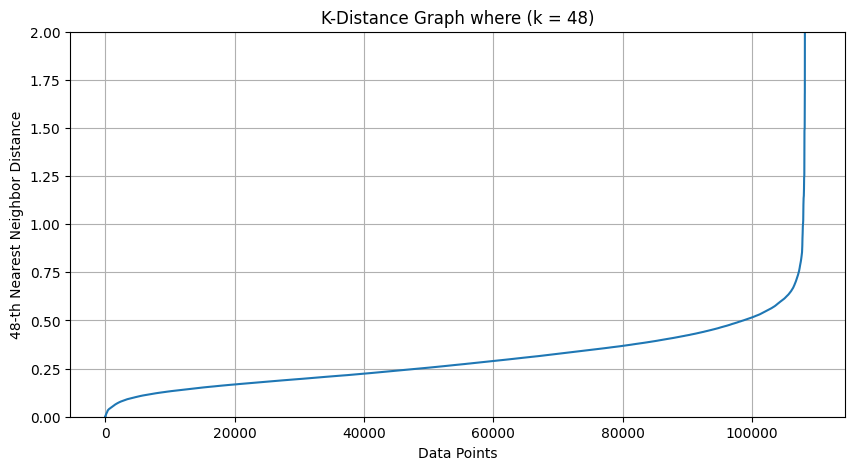

In [ ]:
k = 48 # This is the same as min_samples for DBSCAN. The recommendation is 2 * dimensionality but I found a higher value produces better defined clusters for this dataset.
neighbors = NearestNeighbors(n_neighbors=k, metric='euclidean')
neighbors_fit = neighbors.fit(X_16d)

distances, indices = neighbors_fit.kneighbors(X_16d)
k_distances = distances[:, k - 1] # Get the k-th distance for each point.

k_distances = np.sort(k_distances)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.title(f"K-Distance Graph where (k = {k})")
plt.xlabel("Data Points")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.ylim(0, 2)
plt.grid(True)
plt.show()

Based on this graph, it looks like a value of around 0.6 will work nicely for epsilon, as this the point where the graph turns sharply, indicating the maximum distance when core points are still in dense regions.

Now we can run DBSCAN with the obtained epsilon value.

It will be evaluated qualitatively with a 2D UMAP visualisation and quantitatively with silhouette score and DBCV (Density-based Clustering Validation).

In [ ]:
dbscan = DBSCAN(eps=0.6, min_samples=48, metric='euclidean', n_jobs=-1)
output_labels = dbscan.fit_predict(X_16d)

print("Finished running DBSCAN.")

n_clusters = len(set(output_labels)) - (1 if -1 in output_labels else 0)
n_noise = list(output_labels).count(-1)
n_percluster = [list(output_labels).count(c) for c in set(output_labels) if c != -1]

print(f"Estimated number of clusters: {n_clusters}")
print(f"Number of points for each cluster: {n_percluster}")
print(f"Estimated number of noise points: {n_noise}")

# Remove noise points for silhouette validation
noise_indices = np.where(output_labels == -1)[0]
denoised_X = np.delete(X_16d, noise_indices, axis=0)
denoised_labels = np.delete(output_labels, noise_indices, axis=0)

# Can only run DBCV on a sample of output because it runs out of memory otherwise.
X_df = pd.DataFrame(X_16d)
labels_df = pd.DataFrame(output_labels)
sample_indices = X_df.sample(frac=0.2, random_state=RANDOM_STATE).index
sampled_X = X_df.loc[sample_indices].to_numpy()
sampled_labels = labels_df.loc[sample_indices].to_numpy().ravel()

dbscan_silhouette = silhouette_score(denoised_X, denoised_labels, metric='euclidean')
print(f"Silhouette Score: {dbscan_silhouette}")
dbscan_dbcv = dbcv(sampled_X, sampled_labels, metric='sqeuclidean', noise_id=-1)
print(f"DBCV Score: {dbscan_dbcv}")


Finished running DBSCAN.
Estimated number of clusters: 13
Number of points for each cluster: [105779, 107, 190, 258, 369, 202, 168, 84, 119, 138, 58, 56, 89]
Estimated number of noise points: 1341
Silhouette Score: 0.16535714268684387
DBCV Score: 0.9073555144092155


Map on a 2D UMAP for visualisation

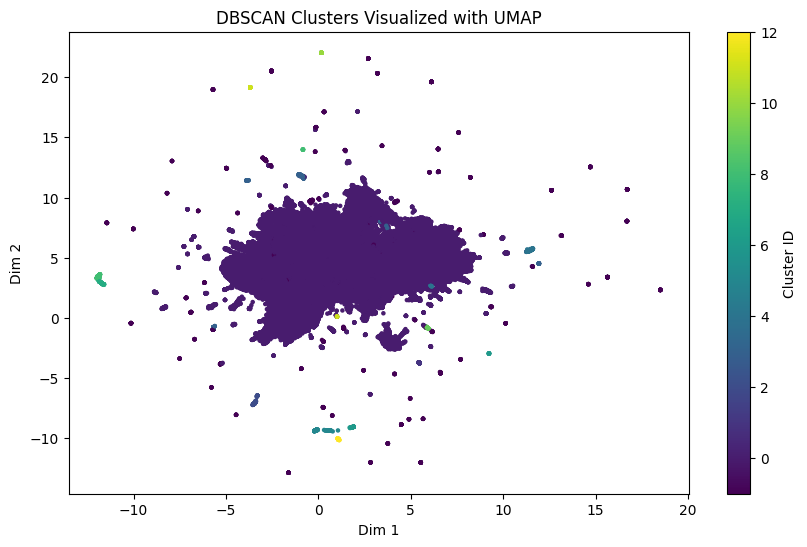

In [21]:
X_2d = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean').fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=output_labels, s=5)
plt.title("DBSCAN Clusters Visualized with UMAP")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label='Cluster ID')
plt.show()

### K-Means Clustering on Semantic Embeddings

For K-means, we found the best k value to use by simply iterating through every value of k from 2 to 30. We would have gone higher if needed but the results proved that to be unnecessary. Similarly to DBSCAN, we will reduce the dimensions down to 16 before running the clustering algorithm.

In [14]:
X = np.vstack(semantic_dataset['doc_vector'].to_numpy())

X_16d = umap.UMAP(n_components=16, n_neighbors=15, min_dist=0.1, n_jobs=-1, metric='euclidean').fit_transform(X)
X_16d = np.nan_to_num(X_16d)

Iterate through many k-values to find the best one (this takes a really long time to run)

In [ ]:
def choose_k(X, kmin, kmax):
    # Run MiniBatchKMeans for different k values
    rows = []
    best_sil = -1
    best_k = None

    for k in range(kmin, kmax + 1):
        print(f"Testing k={k}")
        km = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, batch_size=512)
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels)
        rows.append({"k": k, "silhouette": sil})
        if sil > best_sil:
            print(f"New best k found at k={k}")
            best_sil, best_k = sil, k

    return pd.DataFrame(rows), best_k

scores, best_k = choose_k(X_16d, 2, 30)

print(f"The best k-value found was {best_k}")

The best-found k value was 6 (not shown as output for the above cell as it was actually run earlier in a different file), so we will train a new K-Means model with n_clusters=6 for proper evaluation. The output will be evaluated using silhouette score and DBCV, as well as qualitatively with a 2D UMAP visualisation.

In [15]:
k = 6

kmeans = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, batch_size=512)
labels = kmeans.fit_predict(X_16d)

print("Finished K-Means prediction.")

silhouette = silhouette_score(X_16d, labels, metric='euclidean')
print(f"Silhouette score: {silhouette}")

# Can only run DBCV on a sample of output because it runs out of memory otherwise.
X_df = pd.DataFrame(X_16d)
labels_df = pd.DataFrame(labels)
sample_indices = X_df.sample(frac=0.2, random_state=RANDOM_STATE).index
sampled_X = X_df.loc[sample_indices].to_numpy()
sampled_labels = labels_df.loc[sample_indices].to_numpy().ravel()

dbcv_score = dbcv(sampled_X, sampled_labels, n_processes=8, noise_id=-1)
print(f"DBCV score: {dbcv_score}")

Finished K-Means prediction.
Silhouette score: 0.34491392970085144
DBCV score: -0.9989586551600029


Map on a 2D UMAP for visualisation

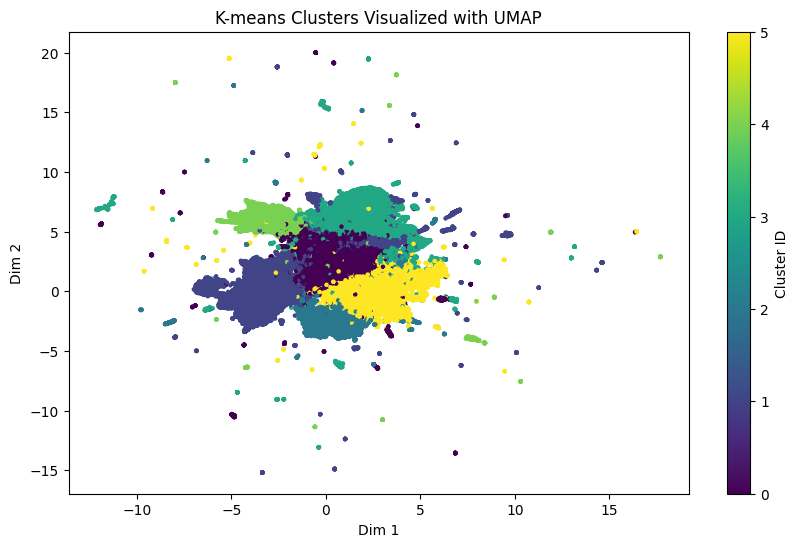

In [22]:
X_2d = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean').fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=5)
plt.title("K-means Clusters Visualized with UMAP")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label='Cluster ID')
plt.show()